In [ ]:
import pandas as pd
import re

In [ ]:
df = pd.read_csv('/secure/shared_data/rag_tnm_results/summary/5_folds_summary/brca_df.csv')

data_lst = []
for i, row in df.iterrows():
    pathology_report = row["text"]
    ground_truth = row["t"]
    filename = row["patient_filename"]

    question_text = f"""
    Based on the following pathology report for a breast cancer patient, determine the pathologic T stage (T1, T2, T3, or T4) for breast cancer, according to the AJCC Cancer Staging Manual (7th edition). 
    Choose from T1, T2, T3, T4.

    {pathology_report}
    """
    data = {"Question": question_text, "Answer": ground_truth, "Filename": filename}
    data_lst.append(data)

# SOAP

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import from_indicators, plot
# To track how many instances of each condition are present in the dataset
# and to visualize the overlap between conditions, we can use UpSet plots.
prob_dict = {
    'myocardial infarction': mi, 
    'congestive heart failure': chf, 
    'pulmonary embolism': pulmonary_embolism, 
    'pulmonary hypertension': pulmonary_hypertension, 
    'sepsis': sepsis, 
    'urosepsis': urosepsis, 
    'meningitis': meningitis, 
    'acute kidney injury': aki, 
    'acute tubular necrosis': atn, 
    'pancreatitis': pancreatitis, 
    'gastrointestinal bleed': gi_bleed, 
    'hepatitis': hepatitis, 
    'cholangitis': cholangitis, 
    'aspiration pneumonia': asp_pneumonia
}
for name, lst in prob_dict.items():
    # df[name] = df['combined_summary'].str.contains('|'.join(lst), regex=True, na=False)
    lst = [term.lower() for term in lst]
    pattern = '|'.join(lst)
    con = (df['combined_summary'].str.contains(pattern, na=False, regex=True) &
        ~df['Subjective'].str.contains(pattern, na=False, regex=True) &
        ~df['Objective'].str.contains(pattern, na=False, regex=True))
    df[name] = con

# UpSet Plot을 위한 데이터셋 생성
binary_df = df[list(prob_dict.keys())]
upset_data = from_indicators(binary_df.columns.tolist(), binary_df)

plt.figure(figsize=(10, 6))
plot(upset_data) 
plt.show()

/home/yl3427/miniconda3/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/yl3427/miniconda3/lib/python3.10/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

<Figure size 1000x600 with 0 Axes>

In [11]:
import pandas as pd
import re

df = pd.read_csv('/home/yl3427/cylab/SOAP_MA/_archive/data/mergedBioNLP2023.csv',
                 usecols=['File ID', 'Subjective', 'Objective', 'Assessment', 'Summary', 
                          'cleaned_expanded_Summary', 'terms'])

# Fill NaNs with '', lowercase all text
df = df.fillna('').apply(lambda x: x.str.lower())

# Combine relevant columns
df['combined_summary'] = df['Summary'] + df['cleaned_expanded_Summary'] + df['terms']

# Dictionary of problems to search for
prob_dict = {
    'sepsis': ["sepsis", "septic shock"], 
    'acute kidney injury': ["acute kidney injury", " aki", "acute renal failure", " arf"], 
    'myocardial infarction': ["myocardial infarction", "elevation mi", "non-stemi", " NSTEMI", " stemi"],
    'gastrointestinal bleed': ["gastrointestinal bleed", "gi bleed"],
    'congestive heart failure': ["congestive heart failure", " chf", "hfref", "hfpef"]
}

# Prepare a list to collect 5-row dataframes
mini_dfs = []

for disease_name, terms_list in prob_dict.items():
    pattern = '|'.join(re.escape(term) for term in terms_list)

    mask = (
        df['combined_summary'].str.contains(pattern, na=False) &
        ~df['Subjective'].str.contains(pattern, na=False) &
        ~df['Objective'].str.contains(pattern, na=False)
    )
    filtered_df = df[mask]
    filtered_df = filtered_df.head(5)

    print(f"Number of rows for {disease_name}: {filtered_df.shape[0]}")

    mini_dfs.append(filtered_df)

# Combine all mini-dfs (5 per disease) and remove any duplicates by File ID
final_df = pd.concat(mini_dfs).drop_duplicates(subset='File ID')

# Save the results
final_df.to_csv('/home/yl3427/cylab/SOAP_MA/Input/SOAP_5_problems_mini.csv', index=False)

print(final_df.shape)


Number of rows for sepsis: 5
Number of rows for acute kidney injury: 5
Number of rows for myocardial infarction: 5
Number of rows for gastrointestinal bleed: 5
Number of rows for congestive heart failure: 5
(22, 8)


In [12]:
final_df

File ID                                         Assessment  \
3    198989.txt  79 yo f w/ a h/o chf (ef of 20-30%), carotid s...   
11   100326.txt  [**age over 90 382**]f presents with history o...   
27   188769.txt  bacteremia\n atrial fibrillation (afib)\n feve...   
34   199699.txt  68f ventilator-dependent secondary to [**last ...   
39   185887.txt  ms. [**known lastname 12640**] is a [**age ove...   
26   191238.txt  this is a 67 yom with hx of cad s/p cabg x 4 i...   
48   110692.txt  cancer (malignant neoplasm), breast\n hypoxemi...   
55   193955.txt  59yo gentleman with h/o depression admitted wi...   
56   110484.txt  49 yo man with presumed cad, dm who presents w...   
58   187707.txt  assesment: this is a 76 year-old female with a...   
37   193820.txt  myocardial infarction, acute (ami, stemi, nste...   
46   192874.txt  mr. [**known lastname 2367**] is a 61 yo m wit...   
88   105852.txt  82m with history of cad s/p cabg (lima to lad,...   
93   184357.txt  60 y/o f w/ h/o hyperlipidemia presents with s...   
101  111372.txt  hypoxemia\n abdominal pain (including abdomina...   
1    101616.txt  67 y/o m cad s/[**initials (namepattern4) **] ...   
17   109934.txt  gastrointestinal bleed, lower (hematochezia, b...   
45   190911.txt  mr. [**known lastname 6148**] is a lovely 78 y...   
51   187277.txt  this 64m with hiv/aids on haart, hbv, cirrhosi...   
2    102486.txt  81f with h/o chronic eosinophilic lung disease...   
68   103771.txt  a/p: 80 yo f with a bronchiectasis and chf adm...   
75   195298.txt  gastrointestinal bleed, lower (hematochezia, b...   

                                               Summary  \
3    sepsis; altered/depressed ms\n thought to be [...   
11   shock- likely hypovolemic from gi bleed, but m...   
27   fever: given fevers, hypotension and recent in...   
34   # septic shock:; #. lethargy:; . anemia:; diab...   
39   hypoxia: differential includes worsening pna; ...   
26   respiratory failure-hypoxia and hypercarbia; a...   
48   hypercarbic/hypoxic respiratory failure; hypog...   
55   # overdose / altered mental status; depression...   
56    hypoxia; aspiration pna; acute renal failure; dm   
58   pneumoperitoneum; rhabdomyolysis; acute renal ...   
37   nstemi; newly worsened mr; hypotension: acutel...   
46   hypoxemia and hypotension; # le swelling; acut...   
88   nstemi; elevated end lv pressure (44mmhg) and ...   
93                                               stemi   
101  hypoxic respiratory distress; hiatal hernia; s...   
1                     lower gi bleed; hypotension; cad   
17                                    gi bleed; anemia   
45                            gib; cad s/p avr-; . dm:   
51                     ugib; cirrhosis; hiv/aids; htn:   
2    pulmonary embolism; fever; hypotension; oligur...   
68          respiratory distress; bronchiectasis; chf.   
75                 gi bleeding/hypotension:; dchf/htn:   

                                            Subjective  \
3    - id: rec bedside echo\n- continued fluid bolu...   
11   multi lumen - start [**2159-8-12**] 01:36 pm\n...   
27   picc line - start [**2202-6-5**] 02:13 am\ncha...   
34   picc line - stop [**2177-7-16**] 01:30 pm\nart...   
39   transthoracic echo - at [**2186-5-11**] 03:00 ...   
26   nasal swab - at [**2103-5-11**] 04:11 pm\nekg ...   
48   - ct head: no acute icp, e/o moderate chronic ...   
55   overdose\n- had episode of hypotension to sbp ...   
56   -cardiac enzymes rising:  0.27 -> 0.63 -> 1.07...   
58   ct repeated: pneumoperitoneum confirmed withou...   
37   overnight hypotensive to map 47 from 72 about ...   
46   admitted to unit with hypotension and hypoxia,...   
88   arterial line - start [**2169-11-8**] 07:03 pm...   
93   dyspnea\nno events overnight.\ndaypro (oral) (...   
101  [**8-14**]\n- thoracic [**doctor first name 21...   
1    colonoscopy - at [**2171-1-25**] 12:31 pm\n- c...   
17   150 cc blood in stool over night. transfused 3...   
45   ercp - at [**

In [16]:
def build_word_boundary_pattern(terms_list):
    """
    Given a list of terms like ["aki", "arf"],
    returns a regex pattern matching any of them as separate words:
    (?:\baki\b)|(?:\barf\b)
    """
    # Make sure each term is escaped, then join with '|'
    # Use word-boundaries (\b) so partial matches like 'wakil' won't match 'aki'
    escaped_terms = [re.escape(term.strip()) for term in terms_list]
    pattern = r'\b(?:' + '|'.join(escaped_terms) + r')\b'
    return pattern

pattern = build_word_boundary_pattern([
        "congestive heart failure", 
        "chf", 
        "hfref", 
        "hfpef", 
        "hf-ref", 
        "hf-pef", 
        "hf ref", 
        "hf pef"
    ])

for s in ["efaefhchf", "ee chf", "congestive failure", "dffahf pef", "chf"]:
    # Convert sentence to lowercase (if that’s how you normally do your matching).
    if re.search(pattern, s.lower()):
        print(f"MATCHED  -> {s}")
    else:
        print(f"NO MATCH -> {s}")

NO MATCH -> efaefhchf
MATCHED  -> ee chf
NO MATCH -> congestive failure
NO MATCH -> dffahf pef
MATCHED  -> chf


/home/yl3427/miniconda3/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/yl3427/miniconda3/lib/python3.10/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

<Figure size 1000x600 with 0 Axes>

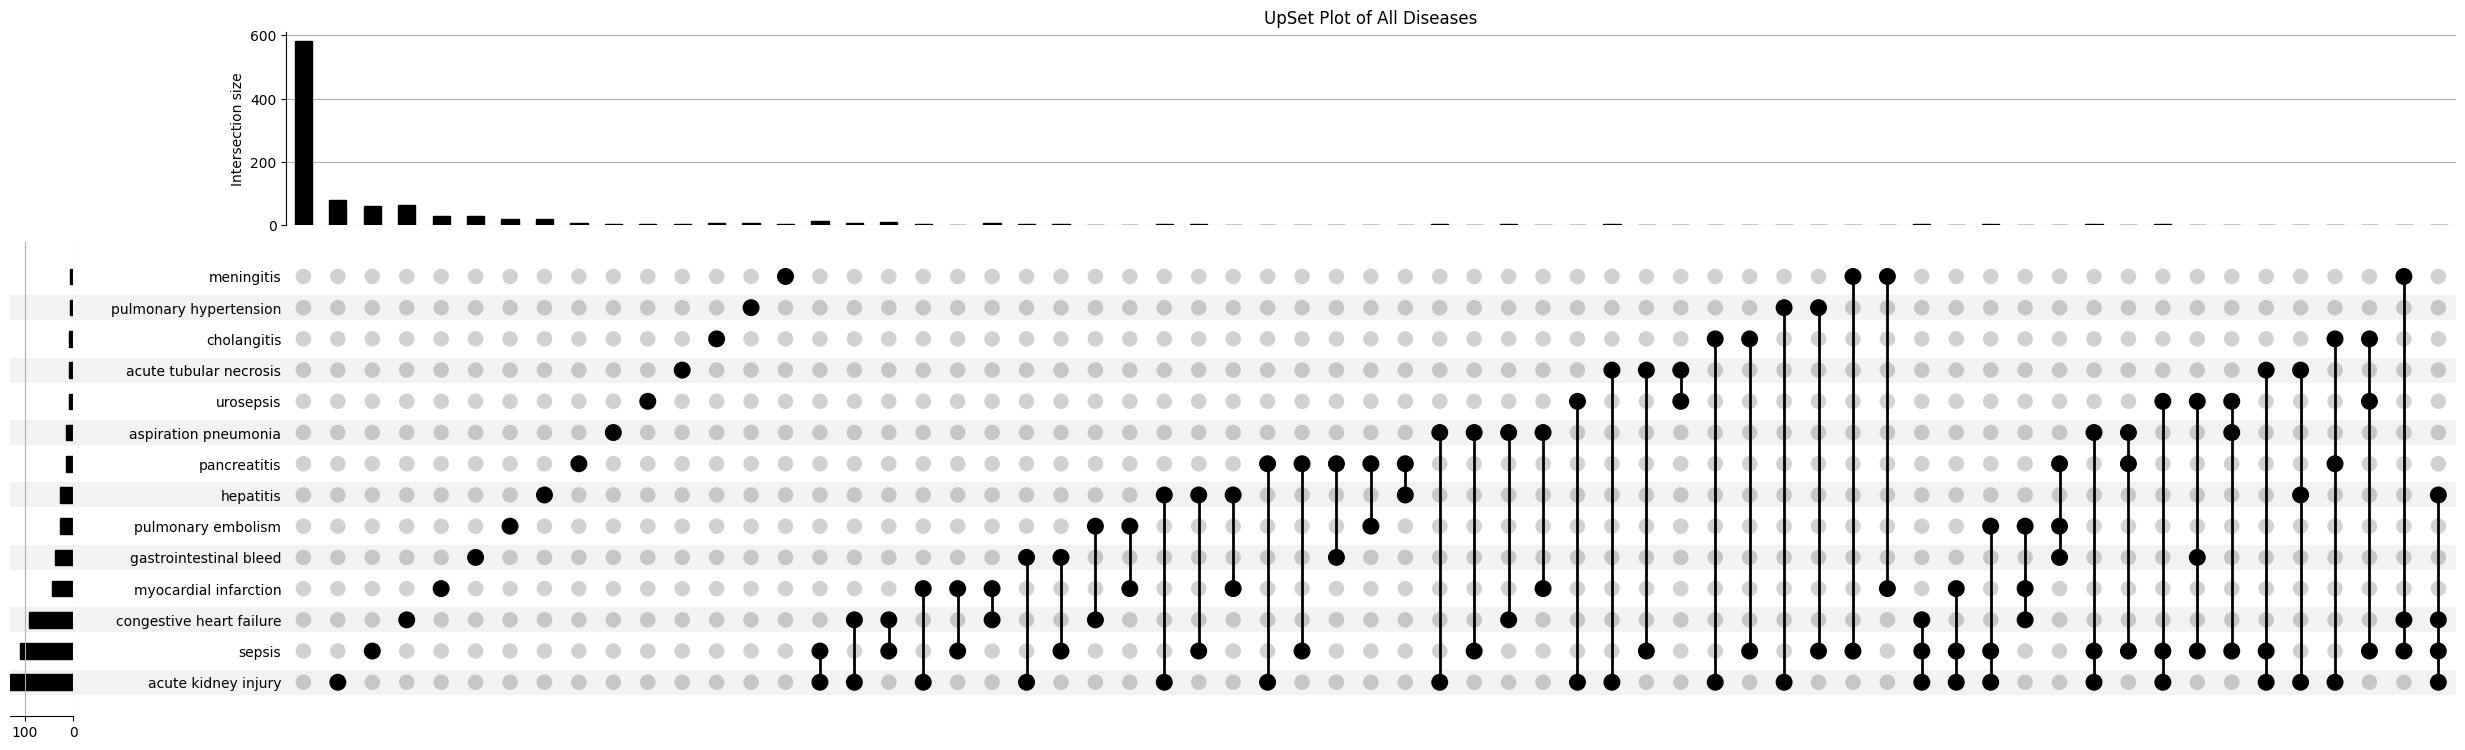

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import from_indicators, plot
import re

#============================#
# 1. LOAD AND PREPARE DATA   #
#============================#

df = pd.read_csv('/home/yl3427/cylab/SOAP_MA/_archive/data/mergedBioNLP2023.csv',
                 usecols=[
                     'File ID',
                     'Subjective',
                     'Objective',
                     'Assessment',
                     'Summary',
                     'cleaned_expanded_Summary',
                     'terms'
                 ])

# Fill NaNs with '' (empty string) and lowercase all text
df = df.fillna('').apply(lambda x: x.str.lower())

# Combine relevant columns into one “combined_summary” for matching.
df['combined_summary'] = df['Summary'] + df['cleaned_expanded_Summary'] + df['terms']


#============================#
# 2. DEFINE MASTER DICTIONARY OF DISEASES #
#============================#

master_prob_dict = {
    'myocardial infarction': [
        "myocardial infarction",
        "elevation mi",
        "non-stemi",
        "nstemi",
        "stemi",
        "nonstemi",
        "non stemi"
    ],
    'congestive heart failure': [
        "congestive heart failure",
        "chf",
        "hfref",
        "hfpef",
        "hf-ref",
        "hf-pef",
        "hf ref",
        "hf pef"
    ],
    'pulmonary embolism': [
        "pulmonary embolism"
    ],
    'pulmonary hypertension': [
        "pulmonary hypertension",
        "pulmonary htn"
    ],
    'sepsis': [
        "sepsis",
        "septic shock"
    ],
    'urosepsis': [
        "urosepsis"
    ],
    'meningitis': [
        "meningitis"
    ],
    'acute kidney injury': [
        "acute kidney injury",
        "aki",
        "acute renal failure",
        "arf"
    ],
    'acute tubular necrosis': [
        "acute tubular necrosis",
        "atn"
    ],
    'pancreatitis': [
        "pancreatitis"
    ],
    'gastrointestinal bleed': [
        "gastrointestinal bleed",
        "gi bleed"
    ],
    'hepatitis': [
        "hepatitis",
        "hep"
    ],
    'cholangitis': [
        "cholangitis"
    ],
    'aspiration pneumonia': [
        "aspiration pneumonia"
    ]
}


#============================#
# HELPER FUNCTION: BUILD WORD-BOUNDARY PATTERN #
#============================#

def build_word_boundary_pattern(terms_list):
    """
    Given a list of terms like ["aki", "arf"],
    returns a regex pattern matching any of them as separate words:
    \b(?:aki|arf)\b
    """
    # Escape all terms, join with '|', and wrap in \b boundaries
    escaped_terms = [re.escape(term.strip()) for term in terms_list]
    pattern = r'\b(?:' + '|'.join(escaped_terms) + r')\b'
    return pattern


#============================#
# 3. CREATE BOOLEAN COLUMNS FOR **ALL** DISEASES #
#============================#
# We'll create columns for every key in master_prob_dict
# so we can visualize everything in the UpSet plot.

for disease_name, terms_list in master_prob_dict.items():
    pattern = build_word_boundary_pattern(terms_list)
    mask = (
        df['combined_summary'].str.contains(pattern, na=False, regex=True) &
        ~df['Subjective'].str.contains(pattern, na=False, regex=True) &
        ~df['Objective'].str.contains(pattern, na=False, regex=True)
    )
    df[disease_name] = mask


#============================#
# 4. VISUALIZE ALL DISEASES WITH UPSET PLOT #
#============================#

all_disease_cols = list(master_prob_dict.keys())  # all boolean columns we just created
binary_df = df[all_disease_cols]
upset_data = from_indicators(binary_df.columns.tolist(), binary_df)

plt.figure(figsize=(10, 6))
plot(upset_data)
plt.title("UpSet Plot of All Diseases")
plt.show()

#---------------------------------------------------#
#     <At this point, you observe the UpSet plot>   #
#  Then decide which diseases you want to keep.     #
#---------------------------------------------------#



In [19]:
#============================#
# 5. SELECT DISEASES & CREATE A MINI DATASET #
#============================#

# Example: After seeing the plot, you choose a subset:
selected_problems = [
    'congestive heart failure',
    'sepsis',
    'acute kidney injury',
]

# Prepare a list to collect mini dataframes
mini_dfs = []

for disease_name in selected_problems:
    # Rebuild the same pattern for the chosen disease
    terms_list = master_prob_dict[disease_name]
    pattern = build_word_boundary_pattern(terms_list)

    # Filter for matching rows
    mask = (
        df['combined_summary'].str.contains(pattern, na=False, regex=True) &
        ~df['Subjective'].str.contains(pattern, na=False, regex=True) &
        ~df['Objective'].str.contains(pattern, na=False, regex=True)
    )
    filtered_df = df[mask]

    # Just take the first 5 for a mini dataset
    # (Use .sample(5, random_state=42) for random selection)
    sampled_df = filtered_df.head(5)

    print(f"{disease_name}: {sampled_df.shape[0]} rows included.")
    mini_dfs.append(sampled_df)

# Combine everything, removing duplicates by File ID
final_df = pd.concat(mini_dfs).drop_duplicates(subset='File ID')

# Save the mini dataset
out_path = '/home/yl3427/cylab/SOAP_MA/Input/SOAP_3_problems_mini.csv'
final_df.to_csv(out_path, index=False)

print(f"Final mini dataset shape: {final_df.shape}")
print(f"Mini dataset saved to: {out_path}")


congestive heart failure: 5 rows included.
sepsis: 5 rows included.
acute kidney injury: 5 rows included.
Final mini dataset shape: (15, 22)
Mini dataset saved to: /home/yl3427/cylab/SOAP_MA/Input/SOAP_3_problems_mini.csv


# MedicalQA 데이터, 5지선다만 골라내기

In [ ]:
!conda update pandas

In [2]:
import pandas as pd
import re

# Read each CSV file into a DataFrame
df1 = pd.read_csv('/home/yl3427/cylab/SOAP_MA/Input/step1_ALL.csv', encoding="utf-8")
df2 = pd.read_csv('/home/yl3427/cylab/SOAP_MA/Input/step2_ALL.csv', encoding="utf-8")
df3 = pd.read_csv('/home/yl3427/cylab/SOAP_MA/Input/step3_ALL.csv', encoding="utf-8")

# Reassign the qn_num values with a prefix for each file
df1['qn_num'] = '1_' + df1['qn_num'].astype(str)
df2['qn_num'] = '2_' + df2['qn_num'].astype(str)
df3['qn_num'] = '3_' + df3['qn_num'].astype(str)

# Concatenate the DataFrames into one
merged_df = pd.concat([df1, df2, df3], ignore_index=True)

# Optionally, view the merged DataFrame
print(len(merged_df))

# Filter rows based on the rule
filtered_rows = []

for _, row in merged_df.iterrows():
    matches = re.findall(r'\b[A-Z](?=[.:])', row['choice'])
    if set(matches) == {'A', 'B', 'C', 'D', 'E'}:
        filtered_rows.append(row)

# Convert the list of rows to a new DataFrame
filtered_df = pd.DataFrame(filtered_rows)

# Optionally, view the new DataFrame
print(len(filtered_df))
filtered_df.to_csv('/home/yl3427/cylab/SOAP_MA/Input/filtered_merged_QA.csv', index=False, encoding="utf-8", lineterminator="\n")

376
284
